### Regularization 구현하기

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.executing_eagerly()
tf.random.set_seed(777)

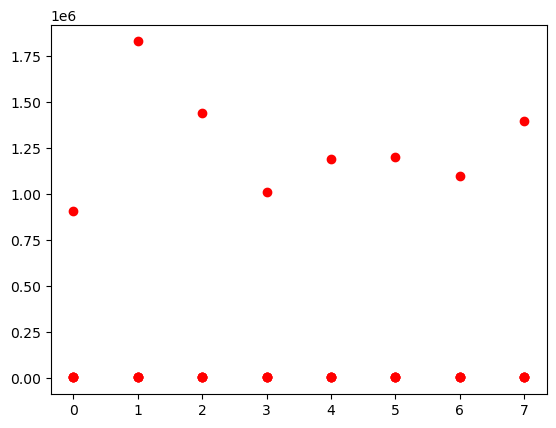

In [2]:
#800대와 엄청 큰 수 같이 선언
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

plt.plot(xy,'ro')
plt.show()

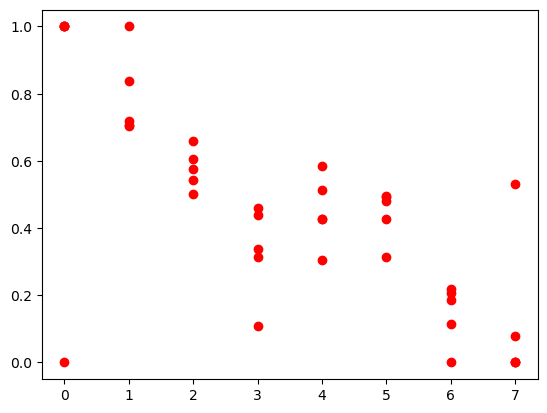

In [3]:
#정규화 기법: 데이터를 0~1사이의 값으로 나타내기
def normalization(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator
xy = normalization(xy)

#학습 데이터 업데이트
x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(xy,'ro')
plt.show()

In [5]:
#학습시킬 데이터셋 가공하기
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

#weight와 bias
W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

In [6]:
#선형회귀 가설 정의: y=Wx+b
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

#선형회귀에 대한 비용 함수
def loss_fn(hypothesis, features, labels, flag = False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels)) #가설과 실제값의 차이를 최소화
    if(flag): #L2_loss 함수를 적용할지 결정
        cost = l2_loss(cost)
    return cost

In [7]:
#Regularization: Overfitting 문제 해결
def l2_loss(loss, beta = 0.01):
    W_reg = tf.nn.l2_loss(W)
    loss = tf.reduce_mean(loss + W_reg * beta) #크게 영향을 주는 weight 값을 완만하게 하기 위해 로스에 특정 값을 추가함으로써 정규화
    return loss

In [8]:
is_decay = True
starter_learning_rate = 0.1

#learning rate decay기법: 특정 지점에서 learning rate 조절
if(is_decay):
    #starter_learning_rate로 시작, 50회마다 0.96을 곱하면서 최적의 loss 값을 찾는다.
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                  decay_steps=50,
                                                                  decay_rate=0.96,
                                                                  staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

#gradient 함수
def grad(hypothesis, features, labels, l2_flag):
    with tf.GradientTape() as tape:
        #실제값과 가설을 비교하고 l2_loss 함수를 적용/미적용 하여 로스값을 구함
        loss_value = loss_fn(linearReg_fn(features),features,labels, l2_flag)
    return tape.gradient(loss_value, [W,b]), loss_value

In [9]:
EPOCHS = 101
for step in range(EPOCHS):
    for features, labels  in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        #선형회귀에 대한 gradient 값을 구하면서 로스값을 출력
        grads, loss_value = grad(linearReg_fn(features), features, labels, False)
        #매 스텝별로 진행을 하면서 learning rate 값을 조절
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))        
    if step % 10 == 0:
        print("Iter: {}, Loss: {:.4f}".format(step,loss_value))

Iter: 0, Loss: 0.5695
Iter: 10, Loss: 0.3125
Iter: 20, Loss: 0.2145
Iter: 30, Loss: 0.1514
Iter: 40, Loss: 0.1094
Iter: 50, Loss: 0.0807
Iter: 60, Loss: 0.0612
Iter: 70, Loss: 0.0472
Iter: 80, Loss: 0.0369
Iter: 90, Loss: 0.0293
Iter: 100, Loss: 0.0236


### Fashion MNIST - Image Classification 구현하기

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(777)

In [11]:
#keras 제공 데이터셋 사용
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#10개의 class 지정
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#정규화
train_images = train_images / 255.0
test_images = test_images / 255.0

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), #크기 지정
    keras.layers.Dense(128, activation=tf.nn.relu), #128개의 layer 지정
    keras.layers.Dense(10, activation=tf.nn.softmax) #10개의 class로 구분
])

#모델 컴파일링
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#모델 훈련
model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

#새로운 데이터로 테스트
predictions=model.predict(test_images)
np.argmax(predictions[0])

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5064 - accuracy: 0.8232
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3798 - accuracy: 0.8624
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3419 - accuracy: 0.8747
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3160 - accuracy: 0.8843
Epoch 5/5
313/313 [==============================] - 0s 778us/step - loss: 0.3590 - accuracy: 0.8748
Test accuracy: 0.8748000264167786
313/313 [==============================] - 0s 651us/step


9

### IMDB - Text classification 구현하기

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.random.set_seed(777)

In [14]:
#keras에서 제공하는 데이터셋
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [15]:
word_index = imdb.get_word_index()
 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index[""] = 0 #공백
word_index[""] = 1 #시작
word_index[""] = 2 #모르는 단어
word_index[""] = 3 #사용되지 않은 단어

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[4])

"? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [16]:
print(train_labels[4])

0


In [17]:
#학습과 평가를 위해 256길이로 동일길이 선언
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index[""],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index[""],
                                                       padding='post',
                                                       maxlen=256)
print(len(train_data[0]), len(test_data[0]))
print(train_data[0])

256 256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  10

In [18]:
vocab_size = 10000

#모델 선언
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu)) #16개의 layer 지정
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

#모델 컴파일
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
#모델을 평가할 test 데이터 정의 - 10000을 기준으로 학습과 평가 수행
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.5381 - val_loss: 0.6909 - val_accuracy: 0.6784
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6880 - accuracy: 0.7215 - val_loss: 0.6848 - val_accuracy: 0.7143
Epoch 3/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6785 - accuracy: 0.7497 - val_loss: 0.6719 - val_accuracy: 0.7370
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6598 - accuracy: 0.7657 - val_loss: 0.6501 - val_accuracy: 0.7647
Epoch 5/40
30/30 [==============================] - 0s 14ms/step - loss: 0.6310 - accuracy: 0.7833 - val_loss: 0.6187 - val_accuracy: 0.7680
Epoch 6/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5926 - accuracy: 0.8020 - val_loss: 0.5807 - val_accuracy: 0.7970
Epoch 7/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5478 - accuracy: 0.8205 - val_loss: 0.5384 - val_accuracy: 0.8128
Epoch 8/40
30

In [20]:
#테스트 데이터로 모델 검증
results = model.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 1s 754us/step - loss: 0.3273 - accuracy: 0.8731
[0.3272671401500702, 0.8730800151824951]
